# Experiments with VAEs!

Some epic stuff in the works

## Imports

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

IM_DIMS = (28, 28)
SAVE_PATH = Path('save/vae_model/')

if not SAVE_PATH.exists():
    SAVE_PATH.mkdir(parents=True)


## Wrangle Data

In [2]:
data = loadmat('mnist.mat')

x_train = torch.from_numpy(data['trainX'].astype('float64') / 256).double()
y_train = torch.from_numpy(np.squeeze(data['trainY']))
x_test = torch.from_numpy(data['testX'].astype('float64') / 256).double()
y_test = torch.from_numpy(np.squeeze(data['testY']))

label:  tensor(6, dtype=torch.uint8)


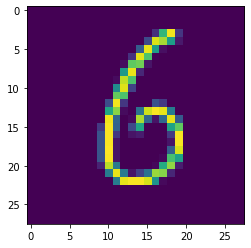

In [11]:
idx = 18
samp = x_train[idx, :].reshape(IM_DIMS)
label = y_train[idx]

plt.imshow(samp)
print('label: ', label)

## Define model

In [39]:
class VAE(nn.Module):

    def __init__(self, latent_dims):
        super(VAE, self).__init__()

        self.latent_dims = latent_dims

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),
        )

        center_size = 64*7*7
        self.fc_mu = nn.Linear(center_size, self.latent_dims)
        self.fc_var = nn.Linear(center_size, self.latent_dims)

        self.decoder_input = nn.Linear(self.latent_dims, center_size)
        self.decoder = nn.Sequential(
            # nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, 
            #                    stride=2, padding=1, output_padding=0),
            # nn.BatchNorm2d(64),
            # nn.LeakyReLU(),
            # nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, 
            #                    stride=1, padding=1, output_padding=0),
            # nn.BatchNorm2d(64),
            # nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, 
                               stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, 
                    stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3),
            nn.Sigmoid()
        )
        # self.decoder = nn.Sequential(
        #     nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, 
        #                        stride=2, padding=1, output_padding=1),
        #     #nn.BatchNorm2d(32),
        #     #nn.LeakyReLU()
        #     nn.ReLU()
        # )

        # self.final_layer = nn.Sequential(
        #     nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, 
        #                        stride=2, padding=1, output_padding=1),
        #     #nn.BatchNorm2d(32),
        #     #nn.LeakyReLU(),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, padding=1),
        #     # nn.Tanh()
        # )
    

    def encode(self, data: 'Tensor') -> 'List[Tensor]':
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param data: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """

        result = self.encoder(data)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]


    def decode(self, z: 'Tensor') -> 'Tensor':
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """

        result = self.decoder_input(z)
        result = result.view(-1, 64, 7, 7)
        result = self.decoder(result)
        # result = self.final_layer(result)
        return result


    def reparameterize(self, mu: 'Tensor', logvar: 'Tensor') -> 'Tensor':
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    
    def forward(self, data: 'Tensor', **kwargs) -> 'List[Tensor]':
        mu, log_var = self.encode(data)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), data, mu, log_var]
    

    def loss_function(self, recons, data, mu, log_var, kld_weight=1) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """

        recons_loss = 0.5 * F.mse_loss(recons, data, reduction='sum')
        kld_loss = torch.sum(-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim = 1), dim = 0)
        # recons_loss = F.mse_loss(recons, data, reduction='mean')
        # kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim = 1), dim = 0)
        loss = (recons_loss + kld_weight * kld_loss) / 32 # TODO: update with batch_size
        return {'loss': loss, 'mse':recons_loss, 'kld':-kld_loss}
    

    def sample(self, num_samples:int) -> 'Tensor':
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """

        z = torch.randn(num_samples, self.latent_dims).double()

        # TODO: for gpu power:
        # z = z.to(current_device)

        samples = self.decode(z)
        return samples
    

    def reconstruct(self, x: 'Tensor', **kwargs) -> 'Tensor':
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]


## Train

In [40]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

vae = VAE(latent_dims=20).to(device=device)
vae = vae.double()

optimizer = optim.Adam(vae.parameters())

def build_dataset(data, labels, batch_size=32):
    """
    Constructs batched data for training
    :param data: (np.array) [N x D]
    :param labels: (np.array) [N]
    :return (batch, labels)
    """

    size = data.shape[0]

    idxs = np.random.permutation(size)
    batches = size // batch_size
    for i in range(batches):
        start_idx = i * batch_size
        stop_idx = (i + 1) * batch_size

        batch = data[start_idx:stop_idx, :].reshape(-1, 1, 28, 28)
        batch_labs = labels[start_idx:stop_idx]

        yield batch, batch_labs, i


def eval(model, test_data, n_samples=1000):
    size = test_data.shape[0]
    idxs = np.random.choice(np.arange(size), n_samples, replace=False)
    x = test_data[idxs, :].reshape(-1, 1, *IM_DIMS)

    with torch.no_grad():
        reco_params = model(x)
        loss = model.loss_function(*reco_params)
    
    return loss
    


In [41]:
epochs = 10
batch_size = 32

log_every = 1000   # num batches
save_every = 1    # num epochs
loss = {}

for e in range(epochs):
    print('epoch: %d of %d' % (e+1, epochs))

    dataset = build_dataset(x_train, y_train, batch_size)
    total_batches = x_train.shape[0] // batch_size

    for x, y, i in dataset:
        optimizer.zero_grad()
        output = vae(x)
        total_loss = vae.loss_function(*output)['loss']
        total_loss.backward()
        optimizer.step()

        if i % log_every == 0:
            vae.eval()
            loss = eval(vae, x_test)
            vae.train()

            print_params = (i+1, total_batches, loss['loss'], loss['mse'], loss['kld'])
            print('[batch %d/%d] loss: %f, mse: %f, kld: %f' % print_params)
        
    if e % save_every == 0:
        torch.save({
            'epoch': e,
            'model_state_dict': vae.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
        }, SAVE_PATH / ('epoch_%d.pt' % e))

print_params = (loss['loss'], loss['mse'], loss['kld'])
print('final loss: %f, mse: %f, kld: %f' % print_params)
torch.save({
    'epoch': epochs,
    'model_state_dict': vae.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
}, SAVE_PATH / 'final.pt')
print('done!')


epoch: 1 of 10
[batch 1/1875] loss: 2592.757887, mse: 82916.966140, kld: -51.286230
[batch 1001/1875] loss: 650.950082, mse: 15158.849322, kld: -5671.553301
epoch: 2 of 10
[batch 1/1875] loss: 666.787464, mse: 15186.953501, kld: -6150.245342
[batch 1001/1875] loss: 628.866835, mse: 14091.399316, kld: -6032.339394
epoch: 3 of 10
[batch 1/1875] loss: 635.985234, mse: 14122.513525, kld: -6229.013968
[batch 1001/1875] loss: 623.870657, mse: 13873.960386, kld: -6089.900623
epoch: 4 of 10
[batch 1/1875] loss: 626.591073, mse: 13718.595940, kld: -6332.318380
[batch 1001/1875] loss: 616.554431, mse: 13483.812436, kld: -6245.929340
epoch: 5 of 10
[batch 1/1875] loss: 625.485460, mse: 13252.237997, kld: -6763.296712
[batch 1001/1875] loss: 603.173768, mse: 12886.990294, kld: -6414.570266
epoch: 6 of 10
[batch 1/1875] loss: 616.605376, mse: 12946.916668, kld: -6784.455356
[batch 1001/1875] loss: 603.929584, mse: 13011.502868, kld: -6314.243825
epoch: 7 of 10
[batch 1/1875] loss: 623.065310, mse: 

## Load model

In [42]:
vae = VAE(latent_dims=20).double()
ckpt = torch.load(SAVE_PATH / 'final.pt')
vae.load_state_dict(ckpt['model_state_dict'])

vae.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (fc_mu): Linear(in_features=3136, out_features=20, bias=True)
  (fc_var): Linear(in_features=3136, out_features=20, bias=True)
  (decoder_input): Linear(in_features=20, out_features=3136, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): Batc

## Fun stuff

torch.Size([1, 1, 28, 28])


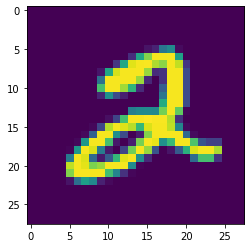

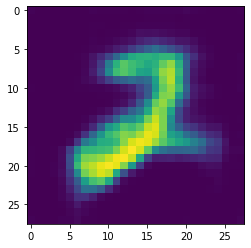

label tensor(2, dtype=torch.uint8)


In [43]:
idx = 5
samp = x_train[idx, :].reshape((-1, 1, *IM_DIMS))
print(samp.shape)
label = y_train[idx]

with torch.no_grad():
    reco = vae.reconstruct(samp)

    reco_im = torch.squeeze(reco)
    samp_im = torch.squeeze(samp)

plt.imshow(samp_im)
plt.show()
plt.imshow(reco_im)
plt.show()
print('label', label)

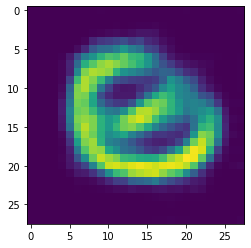

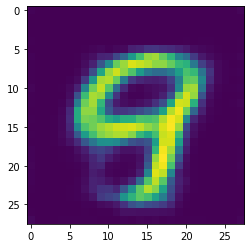

tensor([[1.6448e-03, 1.9779e-05, 5.8711e-07, 6.7637e-07, 3.1643e-06, 7.9763e-06,
         2.4476e-05, 1.9284e-04, 2.1466e-03, 3.6135e-03, 3.0094e-03, 2.4596e-03,
         2.8257e-03, 1.9056e-03, 2.8549e-03, 2.9265e-03, 2.0815e-03, 9.7832e-04,
         1.2351e-03, 2.5987e-03, 5.0800e-03, 1.4414e-03, 3.1740e-04, 4.1017e-05,
         5.3626e-06, 7.2187e-06, 1.1950e-04, 4.6900e-03],
        [4.6537e-05, 5.8018e-08, 4.2963e-09, 9.5092e-09, 1.4201e-07, 8.0473e-08,
         5.8753e-07, 1.3480e-05, 7.0328e-04, 1.1750e-03, 1.5390e-03, 1.3590e-03,
         1.1105e-03, 1.3090e-03, 1.8510e-03, 1.8452e-03, 1.4799e-03, 6.1880e-04,
         8.0764e-04, 7.0136e-04, 2.1183e-03, 1.9358e-04, 3.3017e-05, 3.6028e-06,
         1.3563e-07, 1.6525e-07, 1.1833e-05, 1.7133e-04],
        [3.3240e-06, 4.1341e-09, 8.0748e-10, 2.7084e-09, 3.9075e-08, 1.5709e-08,
         1.6168e-07, 4.7788e-06, 1.2505e-03, 3.0062e-03, 3.2290e-03, 3.8658e-03,
         3.1773e-03, 3.9918e-03, 8.9276e-03, 8.9491e-03, 1.0366e-02, 3.861

In [49]:
with torch.no_grad():
    samp = vae.sample(2)
    samp_im = torch.squeeze(samp)

plt.imshow(samp_im[0,:,:])
plt.show()
plt.imshow(samp_im[1,:,:])
plt.show()

print(samp_im[0,:,:])